# Replication: Zeighami *et al*, 2019

## Introduction

This notebook attempts to reproduce the following paper (which already uses the [PPMI](http://ppmi-info.org) dataset):

<div class="alert alert-block alert-success">
Zeighami, Yashar, et al. <a href=https://doi.org/10.1016/j.nicl.2019.101986>Assessment of a prognostic MRI biomarker in early de novo Parkinson's disease.</a> NeuroImage: Clinical 24 (2019): 101986.
</div>

This study used longitudinal MRI data from 362 patients with de novo PD (i.e., patients not yet taking any medication) and 112 healthy controls. Subjects were split into a main cohort with 3T MRI scans (222 PD patients, 112 healthy controls) and a validation cohort with 1.5T MRI scans (140 PD patients). 

The demographics parameters for the PD patients were as follows (table extracted from the paper):

<img src="images/demographics.png" width=800/>

This paper used a method introduced in [Zeighami *et al* (2015)](https://doi.org/10.7554/eLife.08440) consisting of applying Independent Component Analysis (ICA) to Deformation-Based Morphometry (DBM) maps to identify an atrophy network related to PD. The main result is atrophy measures from this PD network is significantly correlated with disease progression as measured by differences in clinical and/or cognitive scores between the baseline visit and the most recent follow-up visit. This is illustrated in the top row of the following table (extracted from the paper):

<img src="images/results_correlations.png" width=600/>

The authors also showed that the PD-related atrophy score can be used to identify patients who have a 1.5 standard deviation change in the global composite outcome (a measure they defined) between baseline and follow-up visits. The PD-related atrophy biomarker achieved an area under the receiver operating characteristics (ROC) curve of 0.63, out-performing other biomarkers, as shown in the figure below (extracted from the paper):

<img src="images/results_AUC.png" width=500/>

The remainder of this notebook is an attempt to reproduce these results using the same PPMI dataset.

## Initial setup

We first initialize the notebook cache and install dependencies:

In [1]:
import livingpark_utils

utils = livingpark_utils.LivingParkUtils()
utils.notebook_init()

This notebook was run on 2023-01-26 22:26:49 UTC +0000


We import required libraries/functions and load some useful constants and helper functions from the `zeighamietal` module of `livingpark_utils`. The code used to create the initial cohorts based on T1 data availability is reused in another notebook.  

In [2]:
import os
import re
from functools import reduce

import numpy as np
import pandas as pd

from livingpark_utils.zeighamietal.constants import (
    FILENAME_PARTICIPANT_STATUS,
    FILENAME_DEMOGRAPHICS,
    FILENAME_PD_HISTORY,
    FILENAME_AGE,
    FILENAME_MOCA,
    FILENAME_UPDRS1A,
    FILENAME_UPDRS1B,
    FILENAME_UPDRS2,
    FILENAME_UPDRS3,
    FILENAME_ADL,
    FILENAME_T1_INFO,
)

from livingpark_utils.zeighamietal.constants import (
    COL_PAT_ID,
    COL_STATUS,
    COL_VISIT_TYPE,
    COL_DATE_INFO,
    COL_DATE_BIRTH,
    COL_DATE_PD,
)

from livingpark_utils.zeighamietal.constants import (
    STATUS_PD,
    STATUS_HC,
    MAIN_COHORT,
    VALIDATION_COHORT,
    VISIT_BASELINE,
    VISIT_SCREENING,
    REGEX_VISIT_FOLLOWUP,
    SEX_MALE,
    MAX_DATES,
)

from livingpark_utils.zeighamietal.constants import (
    COL_PD_STATE,
    COL_SEX,
    COL_UPDRS1A,
    COL_UPDRS1B,
    COL_UPDRS2,
    COL_UPDRS3,
    COL_MOCA,
    COL_ADL,
    COL_UPDRS1,
    COL_PIGD,
    COL_GCO,
    COLS_PIGD_COMPONENTS_UPDRS2,
    COLS_PIGD_COMPONENTS_UPDRS3,
    COLS_PIGD_COMPONENTS,
    COLS_SCORES_WITHOUT_GCO,
    COL_FOLLOWUP,
)

from livingpark_utils.zeighamietal import (
    load_ppmi_csv,
    get_t1_cohort,
    mean_impute,
    filter_date,
)

## PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study (Table 1) as closely as possible. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Study data download

We will start by downloading the PPMI Study Data files required to build our cohort: 

* Participant status (Parkinson's disease, healthy control, etc.)
* Demographics
* Age at visit
* Clinical/cognitive assessment results:
    * Montreal Cognitive Assessment (MoCA)
    * Unified Parkinson's Disease Rating Scale (UPDRS) Parts I, II and III
    * Modified Schwab and England Activities of Daily Living scale

We will use the LivingPark utils library to download these files from the notebook. If files are already present in the notebook cache, they won't be downloaded again. Otherwise, a PPMI username and password are required to obtain the files. New PPMI accounts can be requested [here](http://ppmi-info.org).

In [3]:
required_files = [
    FILENAME_PARTICIPANT_STATUS,
    FILENAME_PD_HISTORY,
    FILENAME_DEMOGRAPHICS,
    FILENAME_AGE,
    FILENAME_MOCA,
    FILENAME_UPDRS1A,
    FILENAME_UPDRS1B,
    FILENAME_UPDRS2,
    FILENAME_UPDRS3,
    FILENAME_ADL,
]

downloader = livingpark_utils.download.ppmi.Downloader(utils.study_files_dir)
utils.get_study_files(required_files, default=downloader)

Download skipped: No missing files!


### Subjects with T1 MRI available

The paper uses a main cohort and a validation cohort. The **main cohort** consists of subjects with 3T T1 scans and is a subset of the cohort the authors used in the 2015 paper. The **validation cohort** consists of subjects with 1.5T T1 scans.

***Main cohort***

The main cohort was made up of of 222 PD patients and 112 healthy controls. In the 2015 paper, the authors used data from 237 PD patients and 118 healthy controls. MRI processing failure led to the exclusion of 5 PD patients and 1 healthy control, and so the final cohort consisted of 232 PD patients and 117 healthy controls. In the 2019 paper, an additional 10 PD patients and 5 healthy controls were excluded due to lack of follow-up data required in the analysis.

*Note*: In the 2015 paper, the authors state that they used scans acquired from September 2013 to January 2014. However, if we restrict our search to this time period, the number of available scans is much lower than expected (38 PD patients instead of 237, 1 healthy control instead of 118). If we instead use all subjects with 3T scans from January 31st 2014 and before, we obtain 236 PD patients and 113 healthy controls, which is closer to what we expect thought still not exactly the same.

***Validation cohort***

The validation cohort was made up of 140 PD patients. The paper states that data were downloaded in October 2017, so we use all subjects with 1.5T scans from October 31st 2017 and before. 

In [4]:
df_status = load_ppmi_csv(utils, FILENAME_PARTICIPANT_STATUS)

cohort_t1_map = {}
for cohort_name in [MAIN_COHORT, VALIDATION_COHORT]:

    print(f"=============== {cohort_name.capitalize()} cohort ===============")

    df_t1_subset = get_t1_cohort(
        utils,
        cohort_name=cohort_name,
        filename=FILENAME_T1_INFO,
        sagittal_only=True,
    )
    cohort_t1_map[cohort_name] = df_t1_subset

    # cohort composition: number of PD patients/healthy controls
    print(
        df_status.loc[
            df_status[COL_PAT_ID].isin(df_t1_subset[COL_PAT_ID]), COL_STATUS
        ].value_counts()
    )

=============== Main cohort ===============
Removing extra scans for 1 subjects
Parkinson's Disease    236
Healthy Control        113
Name: COHORT_DEFINITION, dtype: int64
=============== Validation cohort ===============
Removing extra scans for 3 subjects
Parkinson's Disease    130
Name: COHORT_DEFINITION, dtype: int64


### Remove subjects with no follow-up data available

The original paper excluded participants with less than 1 year of follow-up:
* 10 PD patients and 5 healthy controls from their main cohort
* No subjects were removed from the validation cohort

We will identify subjects with less than 1 year of follow-up for the PD progression measures.

First, we load/compute and merge all the required clinical/cognitive measures:
* UPDRS Part I
* UPDRS Part II
* UPDRS Part III
* Modified Schwab and England Activities of Daily Living (ADL) scale
* Postural instability and gait disturbance (PIGD) score
* MoCA

Missing values are imputed with the mean across the entire dataset, except for the MoCA score (handled below).

There are two files associated with UPDRS Part I (IA: Complex behaviors; IB: Partipant questionnaire). We use the sum of the total score in each file.

The PIGD score is defined in [Stebbins et al. 2013](https://doi.org/10.1002/mds.25383) and consists of the mean of a subset of UPDRS (Part II and III) measures.

In [5]:
cols_for_merge = [COL_PAT_ID, COL_DATE_INFO, COL_VISIT_TYPE]

df_updrs1a = load_ppmi_csv(utils, FILENAME_UPDRS1A, cols_to_impute=COL_UPDRS1A)
df_updrs1b = load_ppmi_csv(utils, FILENAME_UPDRS1B, cols_to_impute=COL_UPDRS1B)
df_updrs2 = load_ppmi_csv(
    utils, FILENAME_UPDRS2, cols_to_impute=COLS_PIGD_COMPONENTS_UPDRS2 + [COL_UPDRS2]
)
df_updrs3 = load_ppmi_csv(
    utils, FILENAME_UPDRS3, cols_to_impute=COLS_PIGD_COMPONENTS_UPDRS3 + [COL_UPDRS3]
)
df_adl = load_ppmi_csv(utils, FILENAME_ADL, cols_to_impute=COL_ADL)
df_moca = load_ppmi_csv(utils, FILENAME_MOCA)  # do not impute

df_updrs1 = df_updrs1a.merge(df_updrs1b, on=cols_for_merge)
df_updrs1[COL_UPDRS1] = df_updrs1.loc[:, [COL_UPDRS1A, COL_UPDRS1B]].sum(axis="columns")

# some subjects in the validation cohort have multiple entries on the same date
# one for PDSTATE=ON and one for PDSTATE=OFF
# we drop rows where PDSTATE is ON
# PDSTATE=OFF is the typical functional state when participants have a poor response in spite of taking medications
# PDSTATE=ON is the typical functional state when patients are receiving medication and have a good response
df_updrs3 = df_updrs3.loc[df_updrs3[COL_PD_STATE] != "ON"]

# PIGD score is build from UPDRS (Stebbins et al. 2013)
df_pigd = df_updrs2.merge(df_updrs3, on=cols_for_merge, how="inner")
df_pigd[COL_PIGD] = df_pigd.loc[:, COLS_PIGD_COMPONENTS].mean(axis="columns")

df_updrs1 = df_updrs1.loc[:, cols_for_merge + [COL_UPDRS1]]
df_updrs2 = df_updrs2.loc[:, cols_for_merge + [COL_UPDRS2]]
df_updrs3 = df_updrs3.loc[:, cols_for_merge + [COL_UPDRS3]]
df_adl = df_adl.loc[:, cols_for_merge + [COL_ADL]]
df_pigd = df_pigd.loc[:, cols_for_merge + [COL_PIGD]]
df_moca = df_moca.loc[:, cols_for_merge + [COL_MOCA]]

df_assessments_all = reduce(
    lambda df1, df2: df1.merge(df2, on=cols_for_merge, how="outer"),
    [df_updrs2, df_updrs3, df_adl, df_pigd, df_updrs1, df_moca],
).drop_duplicates()

# some missing values remain even if we use the screening visit score
# we will impute these using the original mean
mean_moca = df_moca[COL_MOCA].mean()

cols_to_impute = [col for col in COLS_SCORES_WITHOUT_GCO if col != COL_MOCA]
df_assessments_all = mean_impute(df_assessments_all, cols_to_impute)

# keep only subjects who have a T1
cohort_assessments_map_orig: dict[str, pd.DataFrame] = {}
for cohort_name, df_t1_subset in cohort_t1_map.items():
    cohort_assessments_map_orig[cohort_name] = df_assessments_all.loc[
        df_assessments_all[COL_PAT_ID].isin(df_t1_subset[COL_PAT_ID])
    ]

Most subjects (including all subjects in the main cohort) took the MoCA during the screening visit, not the baseline visit. We replace the baseline MoCA score by the one from the screening visit. We plot a histogram for the number of days between baseline and screening visits, so check whether it was reasonable to use the screening visit score if the baseline score was not available.

========== MAIN COHORT ==========
Parkinson's Disease    223
Healthy Control        109
Name: COHORT_DEFINITION, dtype: int64
========== VALIDATION COHORT ==========
Parkinson's Disease    124
Name: COHORT_DEFINITION, dtype: int64


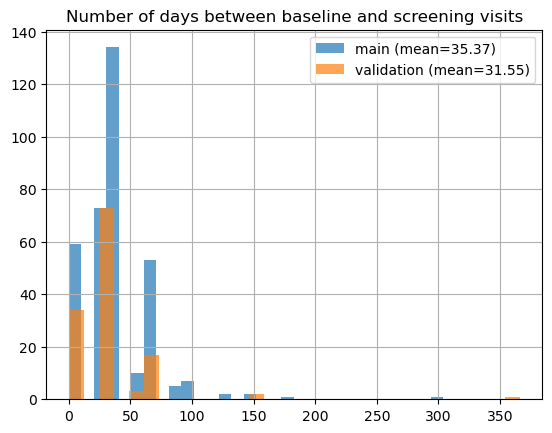

In [6]:
col_date_diff = "date_diff"
max_date_followup = MAX_DATES[VALIDATION_COHORT]

re_followup_compiled = re.compile(REGEX_VISIT_FOLLOWUP)

cohort_assessments_map: dict[str, pd.DataFrame] = {}
for cohort_name in cohort_assessments_map_orig:

    print(f"========== {cohort_name.upper()} COHORT ==========")

    date_diffs = []

    df_assessments_cohort: pd.DataFrame = cohort_assessments_map_orig[cohort_name]
    df_assessments_baseline = df_assessments_cohort.loc[
        df_assessments_cohort[COL_VISIT_TYPE] == VISIT_BASELINE
    ]
    df_assessments_screening = df_assessments_cohort.loc[
        df_assessments_cohort[COL_VISIT_TYPE] == VISIT_SCREENING
    ]

    # try to fill in missing baseline data
    for idx_row_baseline, row_baseline in df_assessments_baseline.iterrows():

        subject = row_baseline[COL_PAT_ID]
        date_baseline = row_baseline[COL_DATE_INFO]

        # for each score columns
        for col in [COL_MOCA]:

            # fill missing values with screening data
            if pd.isna(row_baseline[col]):

                df_screening_subject = df_assessments_screening.loc[
                    df_assessments_screening[COL_PAT_ID] == subject
                ]

                # some subjects in validation set had multiple screening visits
                # in this case we sort them by how close they are to the baseline visit
                n_screening = len(df_screening_subject)
                if n_screening > 1:
                    df_screening_subject[col_date_diff] = (
                        date_baseline - df_screening_subject[COL_DATE_INFO]
                    )
                    df_screening_subject = df_screening_subject.sort_values(
                        col_date_diff, ascending=True
                    )

                # find corresponding assessment score in screening visits
                for idx_row_screening, row_screening in df_screening_subject.iterrows():
                    new_value = row_screening[col]
                    date_diff = date_baseline - row_screening[COL_DATE_INFO]
                    if not pd.isna(new_value):
                        break

                # replace
                if not pd.isna(new_value):
                    df_assessments_baseline.loc[idx_row_baseline, col] = new_value
                    date_diffs.append(date_diff.days)  # for plotting

    # plot baseline-screening date difference
    date_diffs = pd.Series(date_diffs)
    ax = date_diffs.hist(
        bins=30, alpha=0.7, label=f"{cohort_name} (mean={date_diffs.mean():.2f})"
    )

    # pick latest follow-up visit
    df_assessments_followup = df_assessments_cohort.loc[
        (df_assessments_cohort[COL_PAT_ID].isin(df_assessments_baseline[COL_PAT_ID]))
        & (
            df_assessments_cohort[COL_VISIT_TYPE].apply(
                lambda v: re_followup_compiled.match(v)
            )
        )
    ]

    # keep most recent follow-up data up to retrieval date in original paper
    df_assessments_followup = filter_date(
        df_assessments_followup, max_date=max_date_followup
    )
    df_assessments_followup = (
        df_assessments_followup.groupby(COL_PAT_ID)
        .apply(lambda df: df.sort_values(COL_DATE_INFO, ascending=False).head(1))
        .reset_index(drop=True)
    )

    # we keep subjects who have both baseline and follow-up data
    subjects_common = set(df_assessments_cohort[COL_PAT_ID])
    for df_visit in [df_assessments_baseline, df_assessments_followup]:
        subjects_common = subjects_common & set(df_visit[COL_PAT_ID])

    # print cohort composition
    print(
        df_status.loc[
            df_status[COL_PAT_ID].isin(subjects_common), COL_STATUS
        ].value_counts()
    )

    # combine baseline and follow-up
    df_assessments_baseline[COL_FOLLOWUP] = False
    df_assessments_followup[COL_FOLLOWUP] = True
    df_assessments_merged = pd.concat(
        [df_assessments_baseline, df_assessments_followup], axis="index"
    )
    df_assessments_merged = df_assessments_merged.loc[
        df_assessments_merged[COL_PAT_ID].isin(subjects_common)
    ]

    # impute remaining missing MoCA values
    df_assessments_merged.loc[
        df_assessments_merged[COL_MOCA].isna(), COL_MOCA
    ] = mean_moca

    cohort_assessments_map[cohort_name] = df_assessments_merged

# NOTE: date resolution is months
ax.set_title("Number of days between baseline and screening visits")
ax.legend()

### Global composite outcome (GCO) measure

The global composite outcome is the average of the z-scores of the other measures. Following the original paper, we use the mean and standard deviation of the baseline session to compute the z-scores. 

In [7]:
for cohort_name, df_assessments in cohort_assessments_map.items():
    df_assessments_baseline = df_assessments.loc[
        ~df_assessments[COL_FOLLOWUP], COLS_SCORES_WITHOUT_GCO
    ]
    gco_means = df_assessments_baseline.mean()
    gco_stds = df_assessments_baseline.std()
    gco = ((df_assessments[COLS_SCORES_WITHOUT_GCO] - gco_means) / gco_stds).mean(
        axis="columns"
    )
    cohort_assessments_map[cohort_name][COL_GCO] = gco

### Final cohorts

We check the average time between baseline and follow-up visits. In the original paper they report an average of 4.5 years.

In [8]:
dfs_duration = []
for df_assessments in cohort_assessments_map.values():
    dfs_duration.append(
        df_assessments.groupby(COL_PAT_ID).apply(
            lambda df: (
                df.loc[df[COL_FOLLOWUP], COL_DATE_INFO].item()
                - df.loc[~df[COL_FOLLOWUP], COL_DATE_INFO].item()
            )
        )
    )

df_duration = pd.concat(dfs_duration)
print(
    f"{df_duration.mean().days / 365:.3f} "
    f"(\u00B1 {df_duration.std().days / 365:.3f}) years"
)

4.616 (± 1.134) years


Finally, we create a demographics table similar to the one in the original paper:

In [9]:
def to_1_decimal_str(f):
    return str(round(f, 1))


df_age = load_ppmi_csv(utils, FILENAME_AGE)
df_demographics = load_ppmi_csv(utils, FILENAME_DEMOGRAPHICS)
df_pd_history = load_ppmi_csv(utils, FILENAME_PD_HISTORY)

col_male = "is_male"
col_cohort = "cohort"
col_age_diag = "age_diag"

dfs_summary = []
for cohort_name, df_assessments in cohort_assessments_map.items():

    subjects = df_assessments[COL_PAT_ID].drop_duplicates()
    subjects_pd = df_status.loc[
        (df_status[COL_PAT_ID].isin(subjects)) & (df_status[COL_STATUS] == STATUS_PD),
        COL_PAT_ID,
    ]

    # the paper only report measures for the PD patients
    df_assessments = df_assessments.loc[df_assessments[COL_PAT_ID].isin(subjects_pd)]

    df_summary = df_demographics.merge(
        df_pd_history,
        on=[COL_PAT_ID],
    )
    df_summary[col_age_diag] = (
        df_summary[COL_DATE_PD] - df_summary[COL_DATE_BIRTH]
    ) / np.timedelta64(1, "Y")
    df_summary[col_male] = (df_summary[COL_SEX] == SEX_MALE).apply(
        lambda v: 100 if v else 0
    )
    df_summary = df_summary.loc[
        df_summary[COL_PAT_ID].isin(subjects_pd),
        [COL_PAT_ID, col_age_diag, col_male],
    ]
    df_summary[COL_FOLLOWUP] = False

    # combine with clinical/cognitive scores
    df_summary = df_summary.merge(
        df_assessments, on=[COL_PAT_ID, COL_FOLLOWUP], how="outer"
    )
    df_summary = df_summary.drop(columns=COL_PAT_ID)

    # append
    df_summary[col_cohort] = f"{cohort_name} (n = {len(subjects_pd)})"
    dfs_summary.append(df_summary)

df_summary = pd.concat(dfs_summary)
df_summary_means = (
    df_summary.groupby([col_cohort, COL_FOLLOWUP]).mean().applymap(to_1_decimal_str)
)
df_summary_stds = (
    df_summary.groupby([col_cohort, COL_FOLLOWUP]).std().applymap(to_1_decimal_str)
)
df_summary_stds = " (" + df_summary_stds + ")"
df_summary_stds.loc[:, col_male] = ""
df_summary_combined = (df_summary_means + df_summary_stds).T
df_summary_combined = df_summary_combined.applymap(lambda x: "-" if "nan" in x else x)
df_summary_combined = df_summary_combined.rename(
    index={
        col_age_diag: "Age at diagnosis",
        col_male: "Male (%)",
        COL_UPDRS2: "UPDRS Part II",
        COL_UPDRS3: "UPDRS Part III",
        COL_ADL: "S&E ADL",
        COL_PIGD: "PIGD",
        COL_UPDRS1: "UPDRS Part I",
        COL_MOCA: "MoCA",
        COL_GCO: "Global composite outcome",
    }
)
df_summary_combined

cohort                   main (n = 223)              validation (n = 124)  \
is_followup                       False        True                 False   
Age at diagnosis             60.5 (9.3)            -          62.0 (10.2)   
Male (%)                           64.6            -                 59.7   
UPDRS Part II                 5.7 (4.0)   10.8 (7.4)            6.2 (4.3)   
UPDRS Part III               21.5 (9.0)  23.4 (12.1)           19.4 (8.2)   
S&E ADL                      93.5 (5.6)  86.0 (12.1)           92.0 (6.0)   
PIGD                          0.2 (0.2)    0.6 (0.6)            0.3 (0.2)   
UPDRS Part I                  5.4 (3.7)    9.5 (6.3)            6.2 (4.6)   
MoCA                         27.3 (2.2)   26.4 (3.3)           26.4 (2.7)   
Global composite outcome      0.2 (0.4)    0.3 (0.6)            0.0 (0.4)   

cohort                                 
is_followup                     True   
Age at diagnosis                    -  
Male (%)                            -  
UPDRS Part II              10.6 (6.9)  
UPDRS Part III            27.4 (13.4)  
S&E ADL                   81.9 (12.8)  
PIGD                        0.7 (0.7)  
UPDRS Part I                9.9 (6.0)  
MoCA                       26.1 (3.1)  
Global composite outcome    0.2 (0.6)

The values in the table above are generally similar to those obtained in the original paper, though not exactly the same. We were unable to obtain the same number of PD patients as the original paper: we have 223 instead of 222 for the main cohort, and 124 instead of 140 for the validation cohort. Our validation cohort has a smaller percentage of males (59.7%) compared to the original paper (67.9%). Mean clinical and cognitive assessment scores are generally close to those reported in the original paper, with some exceptions (e.g., UPDRS Parts I and III in the follow-up visits for both cohorts).

#### Cohort ID

We generate a cohort ID that uniquely identifies the main/validation cohorts. We will use these IDs to avoid recomputing the same results multiple times.

In [10]:
cohort_ids = {}
fpaths_cohort = {}
for cohort_name, df_assessments in cohort_assessments_map.items():

    # get cohort ID
    cohort_id = livingpark_utils.dataset.ppmi.cohort_id(
        df_assessments.drop_duplicates(COL_PAT_ID)
    )
    print(f"{cohort_name} cohort id: {cohort_id}")

    df_t1 = cohort_t1_map[cohort_name]

    # save patient ids
    filename = f"zeighami-etal-2019-cohort-{cohort_id}.csv"
    df_to_save = df_t1.loc[df_t1[COL_PAT_ID].isin(df_assessments[COL_PAT_ID])]
    df_to_save[COL_PAT_ID] = df_to_save[COL_PAT_ID].astype(np.int64)
    df_to_save.drop_duplicates().sort_values(by=COL_PAT_ID).to_csv(
        filename, index=False
    )
    print(f"\tCohort patient ids saved in {filename}")

    cohort_ids[cohort_name] = cohort_id
    fpaths_cohort[cohort_name] = filename

print("Do not share these files publicly!")

main cohort id: _1606091907888136448
	Cohort patient ids saved in zeighami-etal-2019-cohort-_1606091907888136448.csv
validation cohort id: _7192068301964860554
	Cohort patient ids saved in zeighami-etal-2019-cohort-_7192068301964860554.csv
Do not share these files publicly!


## Download DBM/ICA results from BIC server

Given the large number of subjects in our cohorts, it would be too computationally expensive to compute DBM maps from the notebook. Instead, we will use pre-computed results available from the BIC (the Montreal Neurological Institute's Brain Imaging Center) server.

The code for preprocessing the T1 images and computing the DBM maps is available in the `dbm_ica` directory of this repository. We attempted to follow the original paper's methods as closely possible, though software names and exact versions were not always specified. We implemented the DBM workflow using the MINC toolkit. For the ICA, we used FSL MELODIC to obtain z-statistic maps for each ICA component, as described in the original paper. The complete MRI processing workflow is summarized in the following diagrams:

| DBM pipeline                                        | ICA pipeline                                       |
| :-------------------------------------------------: | :------------------------------------------------: |
| <img src="images/dbm_minc_pipeline.svg" width=500/> | <img src="images/ica_fsl_pipeline.svg" width=400/> |

We used a Singularity container with the MINC toolkit `1.19.16`, FSL `5.0.11` (for the ICA), and some Python packages. The recipe file for this container is available in the `dbm_ica` directory.

**Prerequisites for getting the DBM/ICA results**
1. A BIC account
2. Set up SSH key authentication. There are plenty on online tutorials on how to do this, for example [here](https://www.digitalocean.com/community/tutorials/how-to-configure-ssh-key-based-authentication-on-a-linux-server).
    1. To login from your local machine (on which this notebook is running) to `login.bic.mni.mcgill.ca`
        - **Note**: If you decide to use a passphrase, make sure to use `ssh-add` to avoid being prompted for it when running the notebook. See [here](https://www.ssh.com/academy/ssh/agent#:~:text=The%20ssh%2Dagent%20is%20a,sign%2Don%20(SSO).) for instructions.
    2. To login from `login.bic.mni.mcgill.ca` to `ducky.bic-node.mni.mcgill.ca`
        - This is because we need `singularity`, which isn't available from `login.bic.mni.mcgill.ca`
        - ***IMPORTANT***: Do not use a passphrase here
3. Clone this repository on the BIC server in your home directory:
    ```
    >> cd ~
    >> git clone https://github.com/LivingPark-MRI/zeighami-etal-2019.git
    ```
4. Build the Singularity container using the recipe file in `zeighami-etal-2019/dbm_ica` and copy it to the BIC server in the `zeighami-etal-2019/dbm_ica` directory

In [11]:
from pathlib import Path
import re
import subprocess


def run_singularity_on_bic(
    args: str,
    fpath_container,
    username,
    dpaths_mount=None,
    host="login.bic.mni.mcgill.ca",
):

    if dpaths_mount is None:
        dpaths_mount = []

    components = [f"ssh {username}@{host} ssh ducky nice -n 10 singularity run"]

    for dpath_mount in dpaths_mount:
        components.append(f"--bind {dpath_mount}:{dpath_mount}")

    components.append(fpath_container)
    components.append(args)

    components = [str(component) for component in components if component != ""]
    # print(' '.join(components))
    components = (" ".join(components)).split()  # split on whitespace

    # ssh to BIC and run command
    return subprocess.run(components, capture_output=True)


# TODO store username in file
def check_result_availability(
    cohort_id,
    cohort_file,
    dpath_repo,
    dpath_outputs="outputs",
    fpath_container_rel="dbm_ica/nd-minc_1_9_16-fsl_5_0_11-click_livingpark_pandas_pybids.sif",
    dpath_bids=None,
    dpath_out_dbm=None,
    username=None,
    host="login.bic.mni.mcgill.ca",
    varname_dpath_ica="DPATH_ICA_RESULTS",
    varname_cohort_id="FINAL_COHORT_ID",
    varname_fpath_proc_status="FPATH_PROC_STATUS_COHORT",
    varname_fpath_dbm_list="FPATH_DBM_LIST_COHORT",
):
    def run_scp(source, dest, from_remote=False):
        if from_remote:
            source = f"{username}@{host}:{source}"
        else:
            dest = f"{username}@{host}:{dest}"
        args = [
            "scp",
            "-r",
            source,
            dest,
        ]
        subprocess.run(args)

    def get_var(name, output, sep="=", end="\n"):
        match = re.search(f"{name}{sep}(.*){end}", output)
        if not match or len(match.groups()) != 1:
            raise RuntimeError(f"Did not find name in command output")
        return match.groups()[0]

    # TODO first check if results are already available locally
    # NOTE: cohort IDs might be different, in that case we will have to run things on the BIC server

    if username is None:
        username = input("Please enter your BIC username: ")

    dpaths_mount = [
        dpath for dpath in [dpath_repo, dpath_bids, dpath_out_dbm] if dpath is not None
    ]

    dpath_repo = Path(dpath_repo)
    fpath_container = dpath_repo / fpath_container_rel
    fpath_script = dpath_repo / "dbm_ica" / "check_results_availability.sh"

    # copy cohort file to BIC
    run_scp(cohort_file, dpath_repo, from_remote=False)

    completed = run_singularity_on_bic(
        args=f"{fpath_script} {cohort_id}",
        fpath_container=fpath_container,
        dpaths_mount=dpaths_mount,
        username=username,
        host=host,
    )
    output = completed.stdout.decode("utf-8")
    print(output)

    if completed.returncode != 0:
        error = completed.stderr.decode("utf-8")
        print(f"STDERR:\n{error}")
        raise RuntimeError(
            f"Error running script on BIC (returned {completed.returncode})"
        )

    # parse output
    dpath_results_remote = get_var(varname_dpath_ica, output)
    final_cohort_id = get_var(varname_cohort_id, output)
    fpath_proc_status_remote = get_var(varname_fpath_proc_status, output)
    fpath_dbm_list_remote = get_var(varname_fpath_dbm_list, output)

    # copy ICA results from BIC
    dpath_results_local = Path(dpath_outputs) / Path(dpath_results_remote).name
    fpath_proc_status_local = (
        Path(dpath_results_local) / Path(fpath_proc_status_remote).name
    )
    fpath_dbm_list_local = Path(dpath_results_local) / Path(fpath_dbm_list_remote).name

    if fpath_dbm_list_local.exists():
        print("ICA results have already been downloaded, skipping scp")
    else:
        run_scp(dpath_results_remote, dpath_results_local, from_remote=True)

    return (
        final_cohort_id,
        dpath_results_local,
        fpath_proc_status_local,
        fpath_dbm_list_local,
    )

We download ICA results for the main cohort. If the DBM maps are available but the ICA results are not, this will compute the ICA (which could take a few hours), and it might be necessary to rerun this cell once the ICA is done.

In [12]:
_, dpath_outputs, _, _ = check_result_availability(
    cohort_id=cohort_ids[MAIN_COHORT],
    cohort_file=f"zeighami-etal-2019-cohort-{cohort_ids[MAIN_COHORT]}.csv",
    dpath_repo="/data/origami/livingpark/zeighami-etal-2019/",
)

Some packages in this Docker container are non-free
If you are considering commercial use of this container, please consult the relevant license:
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Licence
-----------------------------------
| COHORT_ID: _1606091907888136448 |
-----------------------------------
---------------
| BIDS-FILTER |
---------------
[RUN] date
Thu Jan 26 17:27:06 EST 2023
--------------------
Loaded BIDS list:		(2065, 8)
Loaded cohort info:		(332, 40) (ID=_1606091907888136448)
4 subjects are not in the BIDS list
Filtered BIDS list:		(338, 48)
Removed up to 14 bad scans:	(328, 48)
COHORT_ID=2228656744226345740
Wrote filtered BIDS list to: /data/origami/livingpark/zeighami-etal-2019/out/dbm/bids_list-_1606091907888136448.txt
[SUCCESS]
--------------------
[RUN] date
Thu Jan 26 17:27:08 EST 2023
-----------------------------------------------------------------------
| COHORT ID CHANGED TO 2228656744226345740 AFTER GENERATING BIDS LIST |
--------------------------------------

We load the scores (average DBM value for each ICA component for each subject) and split them into a PD group and a healthy control group:

In [13]:
df_scores = pd.read_csv(dpath_outputs / "scores.csv", index_col=0)
df_scores.index = df_status.set_index(COL_PAT_ID).loc[
    df_scores.index.astype(np.int64), COL_STATUS
]
df_scores.index.value_counts()

Parkinson's Disease    219
Healthy Control        107
Name: COHORT_DEFINITION, dtype: int64

As in the original study, we use t-tests to determine whether any component is significantly different between the two groups. We apply Bonferonni correction to the p-values to account for multiple comparisons.

In [14]:
from scipy.stats import ttest_ind

correct = True
p_values_data = {}

for component in df_scores.columns:
    t_stat, p = ttest_ind(
        df_scores.loc[STATUS_PD, component],
        df_scores.loc[STATUS_HC, component],
    )
    p_values_data[component] = p

p_values = pd.Series(p_values_data)

if correct:
    p_values = p_values * len(p_values)  # Bonferroni correction

i_components_sorted = np.argsort(list(p_values))
i_component_top = i_components_sorted[0]

p_values.sort_values()

IC14     3.174376
IC24     6.299118
IC28     7.507985
IC30     7.653876
IC6      7.657949
IC25     8.287577
IC29     8.656146
IC22     9.143906
IC12     9.805824
IC16    10.195953
IC21    13.910982
IC10    14.441574
IC18    15.022137
IC9     18.135936
IC1     19.096704
IC7     19.595994
IC13    20.371846
IC27    20.685240
IC19    22.113971
IC15    23.497549
IC23    23.553747
IC11    23.670163
IC2     24.100165
IC4     25.550303
IC26    25.668745
IC17    25.975309
IC20    26.523785
IC8     27.226697
IC5     29.231923
IC3     29.512377
dtype: float64

We plot the DBM score distributions for each IC:

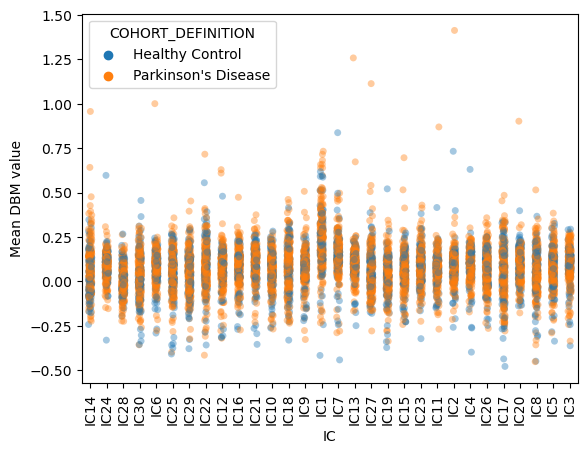

In [15]:
import seaborn as sns

x_label = "IC"
y_label = "Mean DBM value"

df_scores_to_plot = pd.melt(
    df_scores.reset_index(),
    id_vars=[COL_STATUS],
    var_name=x_label,
    value_name=y_label,
)

ax = sns.stripplot(
    df_scores_to_plot,
    x=x_label,
    y=y_label,
    hue=COL_STATUS,
    order=p_values.sort_values().index,
    alpha=0.4,
)
ax.tick_params(axis="x", rotation=90)

None of the corrected p-values reach significance: our lowest p-value is 3.37 compared to 0.003 in the original paper. This means that our replication has failed at this stage, since we are unable to obtain the PD-ICA component presented in the original paper. 

Our top ICA component looks like this:

In [16]:
import nilearn
import nibabel as nib


def plot_IC(fpath, i_component=None, threshold=3, display_mode="z"):
    img = nib.load(fpath)
    if i_component is not None:
        img = nilearn.image.index_img(img, i_component)
    display = nilearn.plotting.plot_stat_map(
        img, threshold=threshold, display_mode=display_mode
    )
    return display

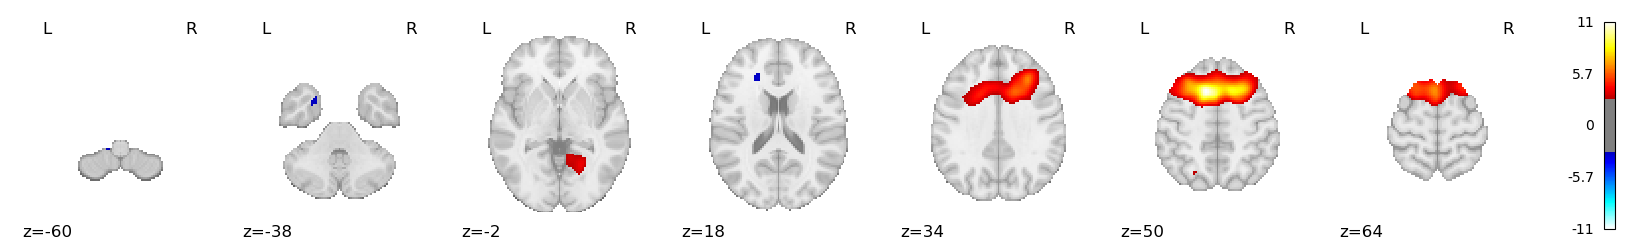

In [17]:
fig_IC = plot_IC(
    dpath_outputs / "melodic_results" / "melodic_IC.nii.gz",
    i_component=i_components_sorted[0],
)

We compare our top ICA component with the PD-ICA component from the original paper (available [here](https://identifiers.org/neurovault.image:12551)):

In [18]:
%%bash
if [ ! -f ${FNAME_PD_ICA} ]
then
    wget "https://neurovault.org/media/images/860/melodic_IC_0007.nii.gz"
else
    echo 'ICA file already exists, skipping download'
fi

ICA file already exists, skipping download


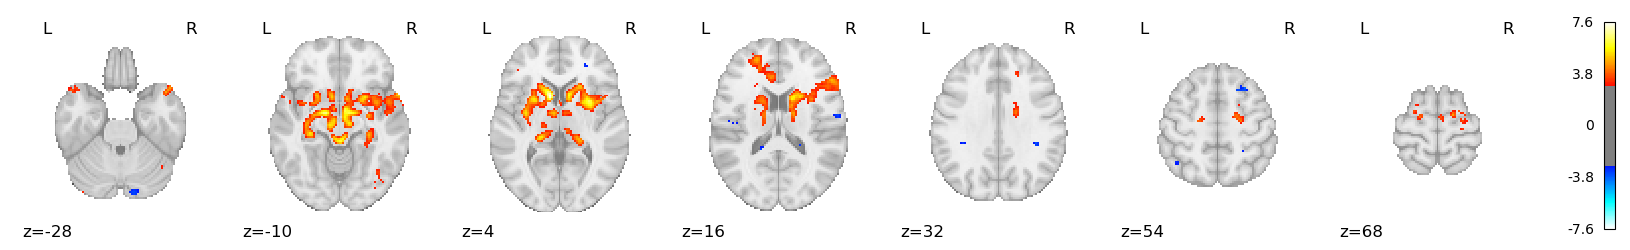

In [19]:
fig_IC_orig = plot_IC("melodic_IC_0007.nii.gz")

Our most significant component does not match the PD-ICA component described in the original study: we obtain regions mostly in the frontal lobe, while the original ICA component mainly includes subcortical regions. Moreover, our clusters tend to be bigger than those in the PD-ICA component, suggesting that there could be inconsistencies in spatial smoothing procedures between our pipeline and the one used in the original study. 